### Einleitung

In diesem Notebook finden Sie eine Anleitung und erklärten Code, um alle Ressourcen (Bilder, Volltexte, PDFs) einer Zeitungsausgabe herunterzuladen, die mit Visual Library gehostet werden. Diese Anleitung ist auch der Einstiegspunkt für weitere Anleitungen, wie man die Ressourcen ganzer Zeitungsunternehmen oder sogar alle Zeitungen einer Sammlung herunterladen kann.

Als Beispiel dient das Zeitungsportal NRW https://zeitpunkt.nrw/, genauer die Ausgabe der Kölnischen Zeitung vom 18. Mai 1848 https://zeitpunkt.nrw/ulbbn/periodical/zoom/8272394.

Wir benutzen ein Python-Skript, um auf den öffentlich zugänglichen OAI/METS-Metadatensatz der Ausgabe zuzugreifen. Dieser enthält Metadaten über die Ausgaben und strukturierte Informationen über die Dateien, die zu dieser Ausgabe gehören.

Diese Anleitung setzt ein Grundverständnis von Python voraus, der Rest sollte hoffentlich durch die Erklärungen verständlich sein.

### Den Metadatensatz finden

Beim Navigieren durch eine Sammlung wie Zeitpunkt NRW endet man üblicherweise im Viewer und schaut sich einzelne Seiten einer Zeitungsausgabe an, wie z.B. hier https://zeitpunkt.nrw/ulbbn/periodical/zoom/8272394.

Diese Ansicht ist für menschliche Benutzer optimiert, für Maschinen dagegen schwer verarbeitbar. Allerdings sind die Informationen, welche Seiten zu welcher Ausgabe gehören, und die Links auf die entsprechenden Dateien auch öffentlich zugänglich, und zwar in Form von OAI/METS-Datensätzen. (Eine kurze Einführung zu diesen folgt im nächsten Abschnitt.) Wir finden den OAI/METS-Datensatz, der zu dieser Ausgabe gehört, durch folgende Navigationsschritte:

Zunächst klicken wir auf das Hamburger-Menü oben rechts und wählen den Jahrgang aus.

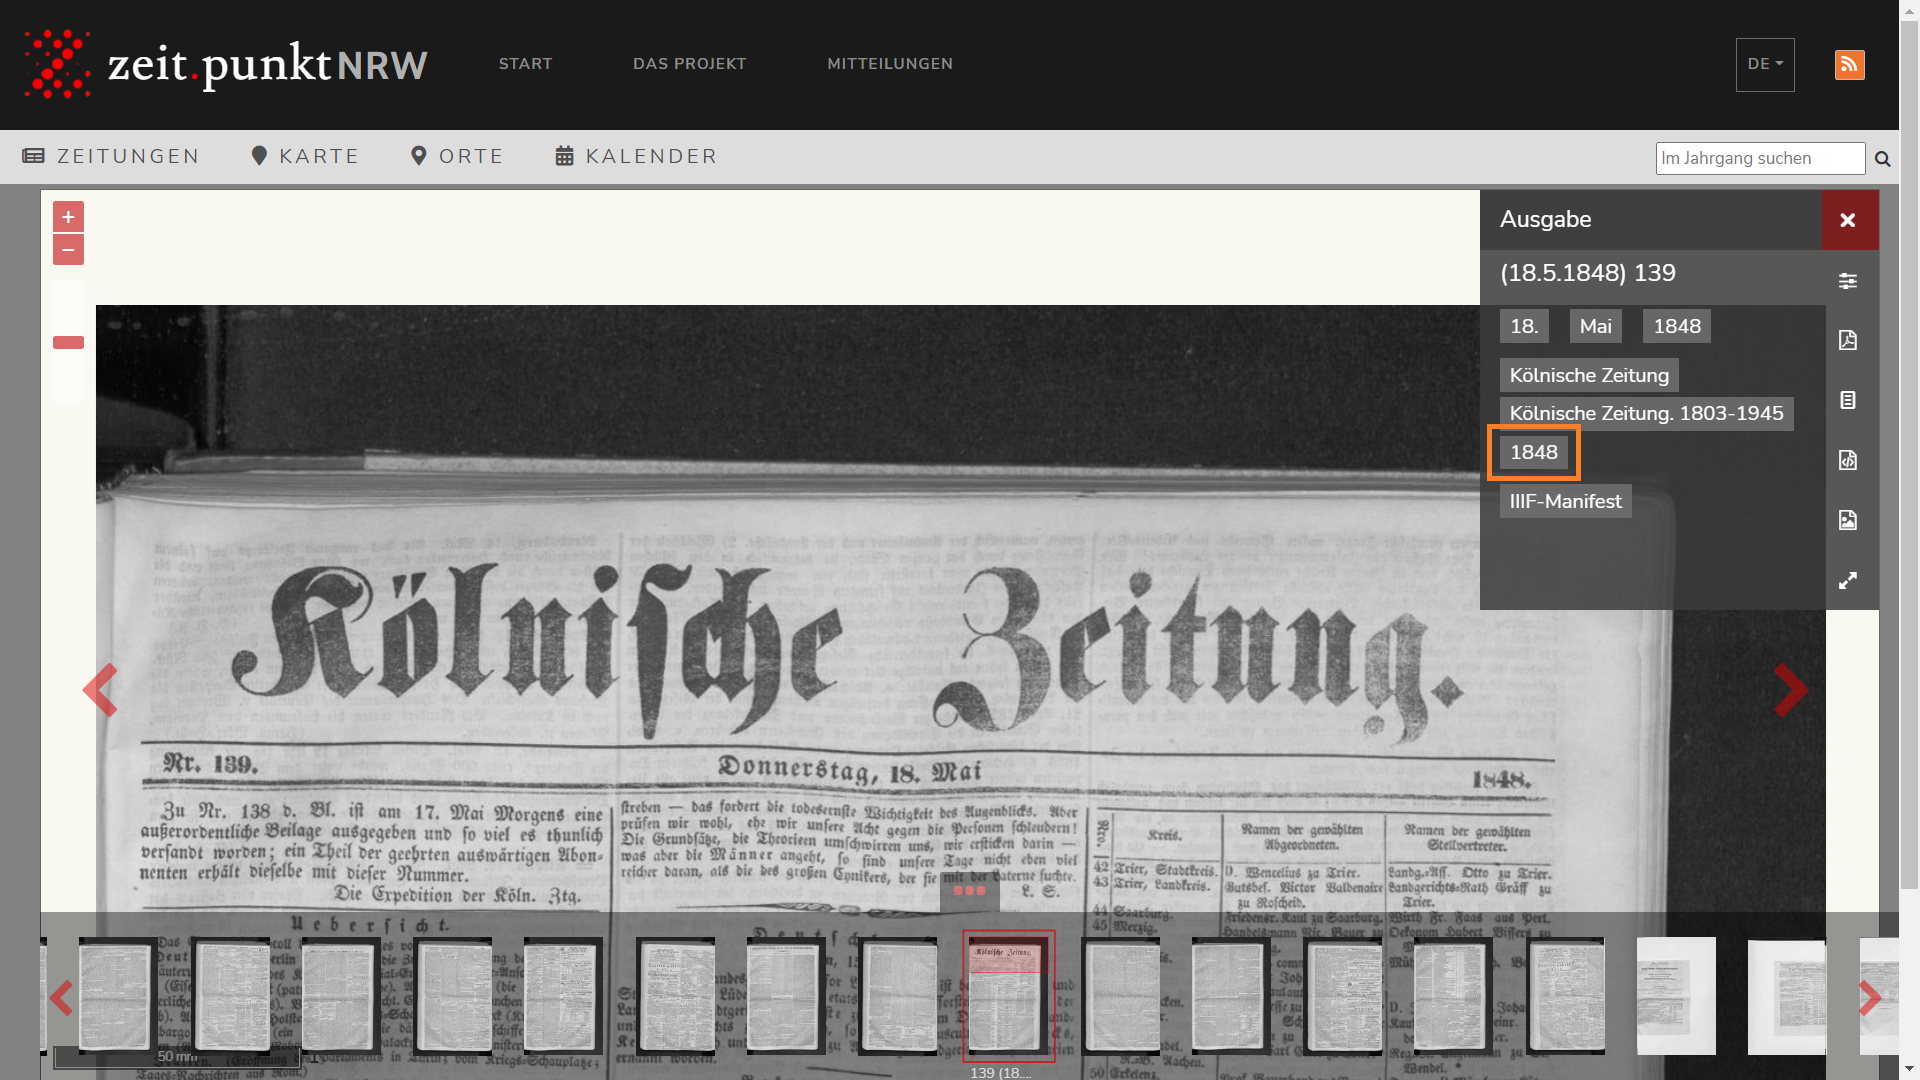

Wir landen auf der Jahrgangsseite (https://zeitpunkt.nrw/ulbbn/periodical/titleinfo/9717394), auf der wir die Ausgabe vom 18. Mai wählen (https://zeitpunkt.nrw/ulbbn/periodical/titleinfo/9715466), und von dort können wir auf den OAI/METS-Datensatz zugreifen:

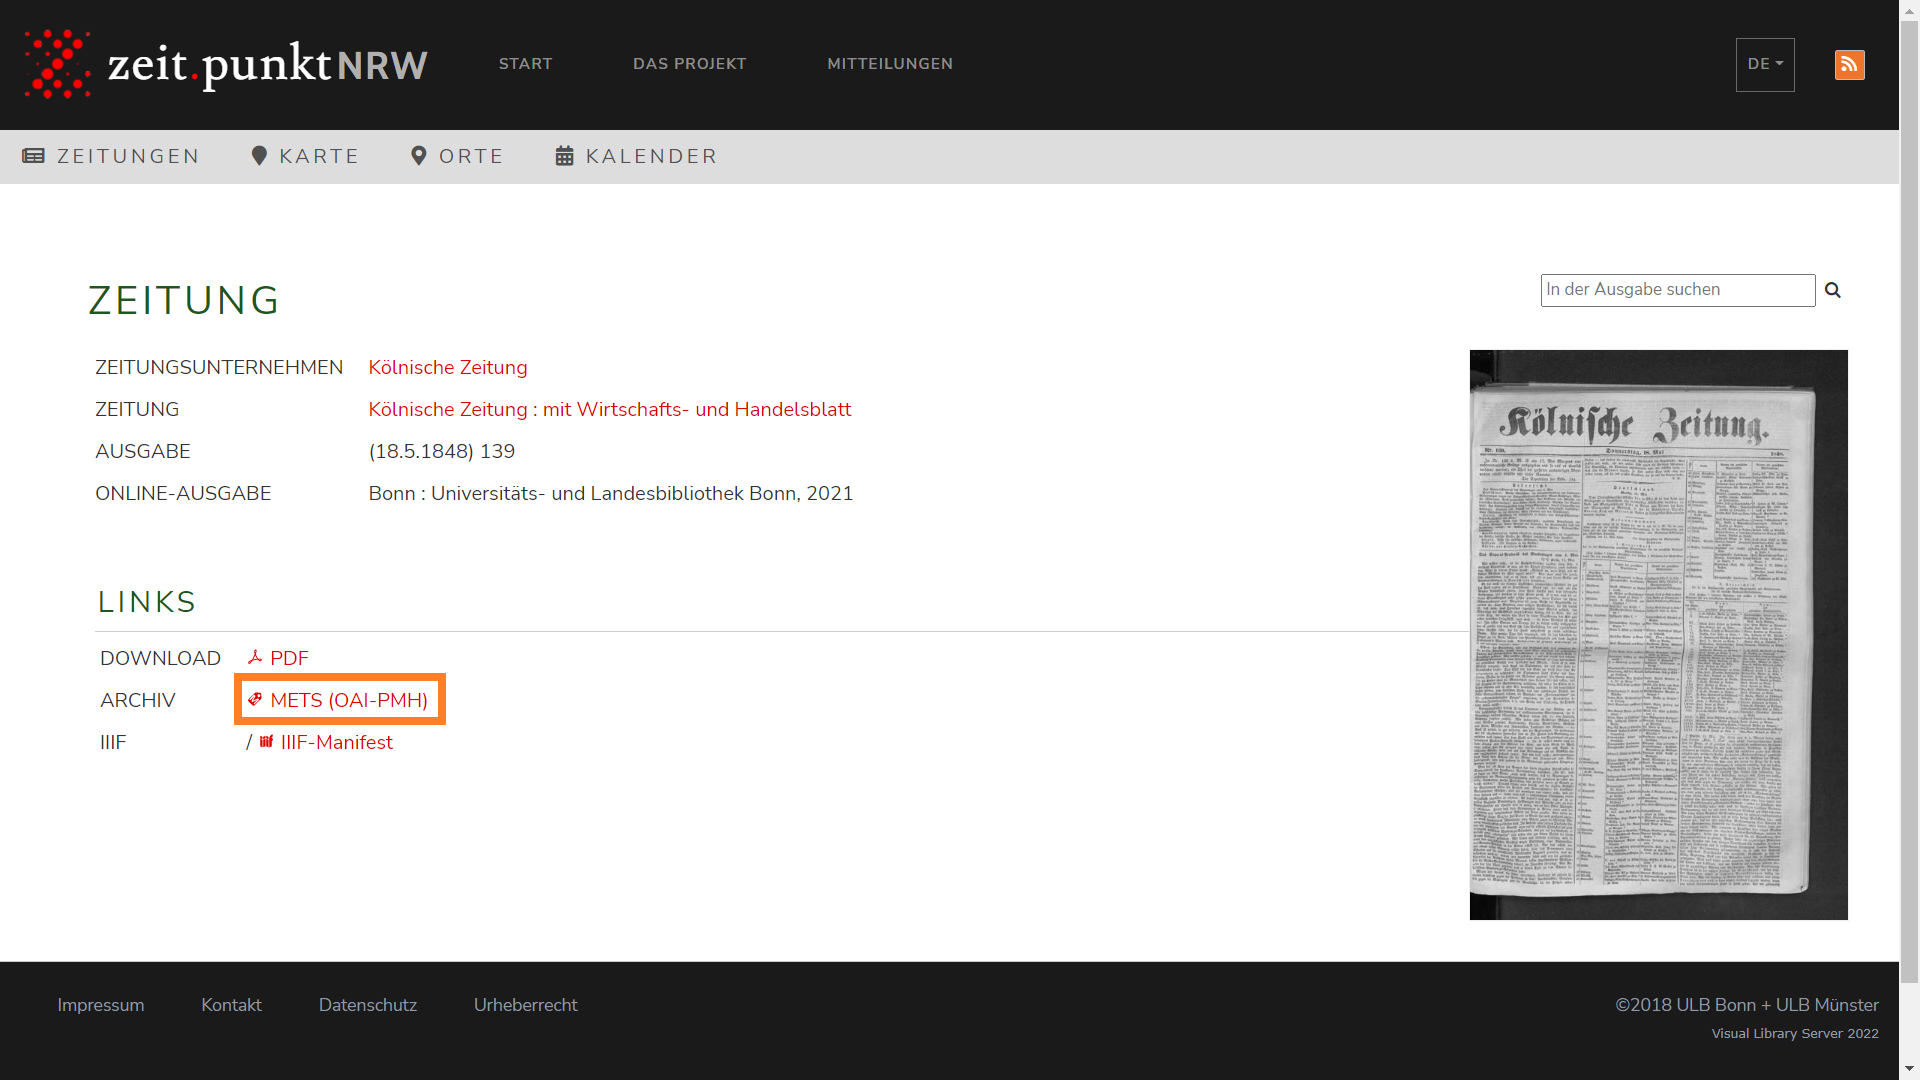

In diesem Datensatz (https://zeitpunkt.nrw/ulbbn/oai/?verb=GetRecord&metadataPrefix=mets&mode=view&identifier=9715466) sind die Metadaten zu dieser Ausgabe gespeichert und Links zu den Dateien, die zu dieser Ausgabe gehören. In der aktuellen Form wird das Dokument in einer visuell etwas übersichtlicheren Form angezeigt. Damit wir es mit Python verarbeiten können, brauchen wir die Rohversion, die wir erhalten, indem wir den "&mode=view"-Paramter in der URL entfernen. So erhalten wir die finale Version, mit der wir weiterarbeiten können: https://zeitpunkt.nrw/ulbbn/oai/?verb=GetRecord&metadataPrefix=mets&identifier=9715466.

Alle Ressourcen, also auch alle logischen Level, aus denen eine Zeitung besteht (Unternehmen, Zeitung, Jahrgang, Ausgabe, Seite), haben eine eindeutige ID, die immer der letzte Teil der URL ist. Das heißt durch Anhängen der ID an den ersten Teil des URL https://zeitpunkt.nrw/ulbbn/oai/?verb=GetRecord&metadataPrefix=mets&identifier= kann man auf den dazugehörigen OAI/METS-Datensatz zugreifen. (Seiten, die das fünfte, unterste logische Level sind, haben zwar auch eine ID, aber liegen direkt vor und nicht als METS-Datensatz, siehe unten.)

### Den Metadatensatz verstehen

Das OAI-Format (genauer: OAI-PMH) dient dem standardisierten Metadatenaustausch. Es ist wie die anderen hier vorgestellten Formate nicht spezifisch für Zeitungen, sondern wird für diverse Arten von Dokumenten genutzt, z.B. auch für Monografien. Man benutzt es üblicherweise, um große Mengen von Metadaten abzurufen oder zu synchronisieren. Da wir hier nur einen einzigen Datensatz verwenden, können wir die OAI-Informationen als eine Hülle betrachten, die wir nicht weiter beachten müssen. Innerhalb dieser Hülle liegen im METS-Format einerseits einige Metadaten vor, z.B. Erscheinungsdatum und -ort, außerdem z.B. Informationen über die Zeitung, zu der die Ausgabe gehört; andererseits aber auch Informationen und Links zu den Einzelseiten und <nobr>-dateien,</nobr> die zu der Ausgabe gehören. Teilweise sind die Metadaten im MODS-Format codiert, das eine noch genauere Klassifikation möglich macht. Alle drei Formate sind XML-Formate und haben daher eine für XML typische Baumstruktur. Da wir in dieser Basisversion die Metadaten nicht auswerten werden, sind alle benötigten Informationen im METS gespeichert. Die volle Spezifikation des Formats findet sich hier: https://dfg-viewer.de/fileadmin/groups/dfgviewer/METS-Anwendungsprofil_2.3.1.pdf.

Wir werden nicht in die Tiefen und Tücken des METS-Datensatzes einsteigen, sondern nur die relevanten Teile betrachten.
Gegen Ende des Datensatzes findet sich das Element <mets:structMap TYPE="PHYSICAL">. Die zehn (Enkel-)Kinder dieses Elements repräsentieren die zehn Seiten dieser Ausgabe. Jedes dieser Kinder besteht aus mehreren Elementen, welche die Ressourcen abbilden, die zu dieser Seite gehören. Die vorhandenen Ressourcen sind das Bild der Seite in vier verschiedenen Auflösungen und der Volltext der Seite. Dieses Verhältnis zwischen Zeitungsausgaben und Ausgabenseiten ist strutkturell mehr oder weniger das gleiche wie zwischen einer Monografie und ihren Seiten.

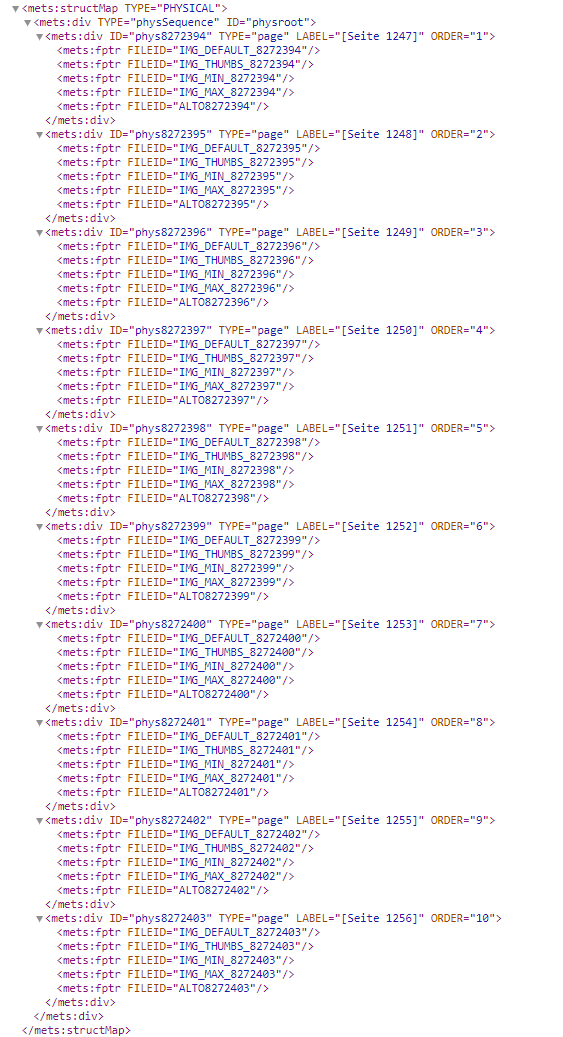

Das zu mets:structMap vorgängige Geschwisterkind ist \<mets:FileSec>. In seinen Kindern sind die Verweise auf die Dateien gespeichert, die zu der Ausgabe gehören. Es hat sechs Kinder der Form <mets:fileGrp USE=...>, welche durch den Wert des USE-Paramters differenziert werden und die verschiedenen Dateitypen abbilden. Der Abschnitt "DOWNLOAD" enthält ein PDF-Dokument der ganzen Ausgabe. Die Abschnitte "DEFAULT", "THUMBS", "MIN" und "MAX" enthalten jeweils JPEG-Bilder aller Seiten, in unterschiedlichen Auflösungen. Der Abschnitt "FULLTEXT" enthält die Volltexte aller Seiten im ALTO-Format. Hier sehen Sie Bild des expandierten 'MAX'-Abschnitt:

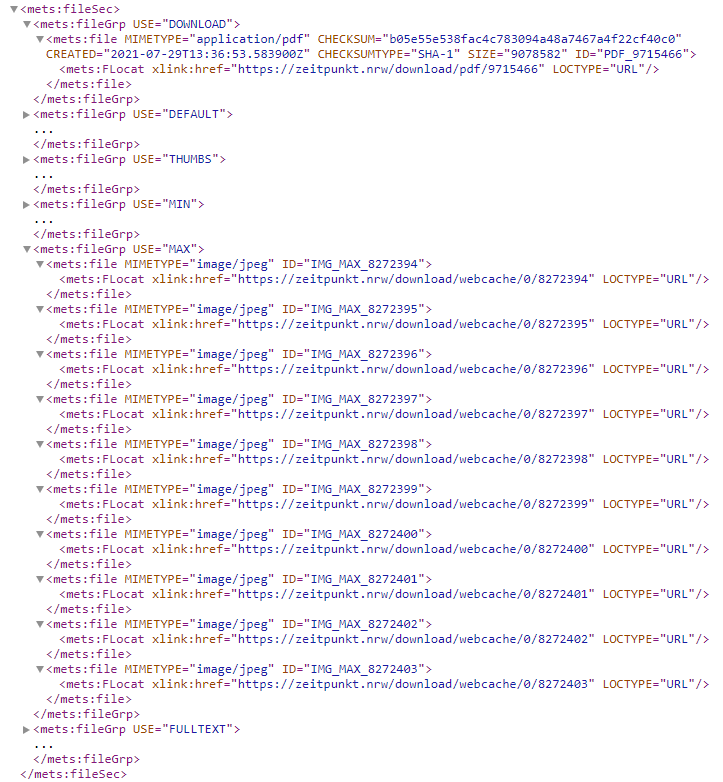

Man kann jeden dieser Links individuell anklicken, bzw. in den Browser kopieren und so die entsprechende Ressource erreichen. Genau diesen Vorgang werden wir im Folgenden automatisieren.

### Automatischer Download der Dateien

Da METS ein XML-Format ist, kann es einfach verarbeitet werden, weil es spezielle (Python-)Bibliotheken dafür gibt. Falls Sie diese noch nicht installiert haben, müssen Sie die Bibliotheken lxml und requests installieren. (Dafür einfach die Raute (#) an den Zeilenanfängen entfernen.)

In [ ]:
# %pip install lxml
# %pip install requests

Wir importieren die Bibliotheken und die Funktionen, die wir benutzen werden.

In [ ]:
from io import StringIO
from mimetypes import guess_extension
from os import makedirs, path
from lxml import etree
import requests

Wir spezifizieren die URL der Zeitung, mit der wir arbeiten werden (Kölnische Zeitung vom 18. Mai 1848):

In [ ]:
url = 'https://zeitpunkt.nrw/ulbbn/oai/?verb=GetRecord&metadataPrefix=mets&identifier=9715466'

Nun nutzen wir die requests-Bibliothek, um die Website, d.i. den METS-Datensatz, in unser Programm zu laden. Danach parsen wir das Dokument mit lxml, sodass das Programm versteht, dass es sich um einen XML-Baum handelt.

In [ ]:
s = requests.Session()
s.headers.update({'User-Agent': 'METS_Downloader'})
r = s.get(url)
tree = etree.parse(StringIO(r.text))
root = tree.getroot()

Anschließend benutzen wir XPath-Abfragen (https://www.w3schools.com/xml/xpath_intro.asp), um die Abschnitte, die wir brauchen, aus dem Dokument zu extrahieren. Dies sind die \<mets:fileSec>-Elemente. In XML-Dokumenten werden üblicherweise Namensräume verwendet, um Kollisionen zwischen Variabelnamen zu verhindern (https://www.w3schools.com/xml/xml_namespaces.asp). Die Verweise auf die Namensräume finden wir im Dokument selbst (üblicherweise direkt am Anfang), sodass wir sie speichern, um XPath-Abfragen durchführen zu können. NB: Diese Namensräume sind dieselben für alle METS-Datensätze der verschiedenen Ressourcen (Zeitungen, Ausgaben, usw.), sodass Sie diese für andere Ressourcen nicht erneut extrahieren müssen.

In [ ]:
ns_map = {'xmlns': "http://www.openarchives.org/OAI/2.0/",
          'mets': "http://www.loc.gov/METS/",
          'xlink': "http://www.w3.org/1999/xlink"}

Wir definieren eine Funktion, die die URL einer Ausgabe und das gewünschte Format übergeben bekommt. Sie extrahiert dann alle Links zu den Ressourcen in diesem Format.

In [ ]:
def get_pages_from_issue(url, fmt):
    """Get pages from an issue-url, provide format which should be extracted, return list of links to pages."""
    r = s.get(url)
    tree = etree.parse(StringIO(r.text))
    root = tree.getroot()
    page_links = root.xpath(f'//mets:fileGrp[@USE="{fmt.upper()}"]//@xlink:href', namespaces=ns_map)
    return page_links

Wir wählen die Formate aus, die wir herunterladen wollen, indem wir sie in einer Liste speichern, über die wir anschließend iterieren. Beachten Sie, dass die Dateinamen für verschiedene Versionen desselben Formats in dieser Basisversion gleich sind (z.B. liegt das Bild einer Seite in verschiedenen Größen (Max, Default, Min, Thumbs) als JPEG vor). Das bedeutet, dass beim Herunterladen mehrerer Ressourcen gleichen Formats die zuletzt heruntergeladene Version frühere Versionen überschreibt. In diesem Fall wird zwar eine Warnung angezeigt, aber das Überschreiben findet trotzdem statt. Im Wesentlichen bedeutet dies, dass dieses Skript nicht ohne Änderungen verwendet werden sollte, um mehrere Versionen desselben Formats in einem Durchgang herunterzuladen.

In [ ]:
# formats = ['Download', 'Default', 'Thumbs', 'Min', 'Max', 'Fulltext']
formats = ['Download', 'Max', 'Fulltext']

Wir geben einen Download-Ordner an und erstellen ihn, falls er noch nicht existiert. Der Pfad dieses Ordners kann absolut oder relativ (zum Ordner, in dem sich dieses Jupyter-Notebook befindet) sein.

In [ ]:
download_path='downloads'

try:
    makedirs(f'{download_path}')
except FileExistsError:
    pass

Wir iterieren über die verschiedenen Formate und rufen für jedes die get_pages_from_issue-Funktion auf, um die Links zu den Seiten zu erhalten. Im Anschluss iterieren wir über diese Links, extrahieren die Seiten-ID und laden mithilfe dieser den Inhalt der Seite herunter.

In [ ]:
for f in formats:
    for page_link in get_pages_from_issue(url, fmt=f):
        r = requests.get(page_link)
        ressource_name = page_link.split('/')[-1]

        # get rid of encoding if provided in r.headers; if not provided: split still works, then guess extension
        filetype = guess_extension(r.headers['Content-Type'].split(';')[0])
        filename = ressource_name + filetype
    
        # throw warning if file will be overwritten
        if path.isfile(f'{download_path}/{filename}'):
            print(f'Warning: {filename} already existed and was overwritten')

        # save file
        with open(f'{download_path}/{filename}', 'wb') as file:
            file.write(r.content)

### Ergebnis

Wenn Sie den Code so ausführen, wie er ist, wird in dem Ordner, in dem sich diese IPYNB-Datei befindet, ein neuer Ordner "downloads" angelegt. Anschließend wird das PDF der gesamten Ausgabe sowie das Bild in maximaler Auflösung und der Volltext für jede Seite heruntergeladen, insgesamt also 21 Dateien.